In [1]:
from pyiron_atomistics import Project
import numpy as np
from typing import Optional

In [2]:
from pyiron_workflow import Workflow
from pyironflow.pyironflow import PyironFlow

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
@Workflow.wrap.as_function_node
def CreateProject(pr_name:str):
    pr = Project(pr_name)
    import os
    os.system('conda env export | grep -v "^prefix: " > ' + pr.path + pr.name + '_environment.yml')
    return pr

In [5]:
@Workflow.wrap.as_function_node
def CreateStructure(pr, structure_name_prefix: str, element:str, bravais_lattice: Optional[str], a: Optional[float|int], c: Optional[float|int] = None, cubic:bool = False):

    import json
    from pyiron_base.storage.hdfio import FileHDFio
    from ob.concept_dict import process_structure_crystal, get_unit_cell_parameters
    
    pr = pr
    if bravais_lattice != 'hcp' and c == None:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a)
    elif bravais_lattice == 'hcp' and c == None:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a)
    else:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a, c=c)

    structure_path = pr.name + '/'
    structure_name = structure_name_prefix + '_input_structure'
    hdf = FileHDFio(structure_path + structure_name + '.h5')
    structure.to_hdf(hdf)

    # Must be conventional unit cell or primitive cell
    # Provide the structure before repetition or any other manipulations
    structure_parameters = get_unit_cell_parameters(structure)
    
    struct_cdict = process_structure_crystal(pr, structure, structure_name, structure_path, structure_parameters)
    
    struct_and_cdict = {'object': structure, 'cdict': struct_cdict}
    
    return struct_and_cdict

In [6]:
@Workflow.wrap.as_function_node("View")
def VisualizeStructure(struct_and_dict):
    return struct_and_dict['object'].plot3d

In [7]:
@Workflow.wrap.as_function_node
def LammpsCalcMinimize(pr, struct_and_cdict, job_name:str, pot_list_index:int, f_tol:float|int, min_style:str, del_ex_job:bool = False, is_child_job = False):
    pr = pr
    structure = struct_and_cdict['object']
    job = pr.create.job.Lammps(job_name=job_name, delete_existing_job=del_ex_job)
    job.structure = structure.copy()
    job.potential = job.list_potentials()[68]
    job.calc_minimize(ionic_force_tolerance=f_tol)

    if is_child_job == False:
        import os
        os.system('conda env export | grep -v "^prefix: " > ' + job.path + '_environment.yml')
    
        from pyiron_base.storage.hdfio import FileHDFio
        hdf = FileHDFio(job.path + '_input_structure.h5')
        job.structure.to_hdf(hdf)
    
    return job

In [8]:
@Workflow.wrap.as_function_node
def MurnaghanJob(pr, job, murn_job_name:str, n_sample_points:int, equation_of_state:str, fit_order:int, volume_range:float|int, 
                 del_ex_job:bool = False):
    pr = pr
    murn = job.create_job(job_type=pr.job_type.Murnaghan, job_name=murn_job_name, delete_existing_job=del_ex_job)
    murn.input['fit_type'] = equation_of_state
    murn.input['num_points'] = n_sample_points
    murn.input['fit_order'] = fit_order
    murn.input['vol_range'] = volume_range
    murn.run()

    import os
    os.system('conda env export | grep -v "^prefix: " > ' + murn.path + '_environment.yml')

    for jobs in murn.iter_jobs():
        from pyiron_base.storage.hdfio import FileHDFio
        os.system('cp ' + murn.path + '_environment.yml ' + jobs.path + '_environment.yml')
    
    return murn

In [9]:
@Workflow.wrap.as_dataclass_node
class MurnaghanParameters():
    murn_job_name: Optional[str] = 'murn'
    n_sample_points: Optional[int] = 7
    equation_of_state: Optional[str] = 'birchmurnaghan'
    fit_order: Optional[int] = 3
    volume_range: Optional[float|int] = 0.05
    job_name: Optional[str] = 'el_str'
    pot_list_index: Optional[int] = 0
    f_tol: Optional[float|int] = 1e-6
    min_style: Optional[str] = 'cg'

In [10]:
@Workflow.wrap.as_macro_node("murn_job")
def MurnaghanLammpsMacro(self, pr, struct_and_cdict, parameters: Optional[MurnaghanParameters.dataclass] = MurnaghanParameters.dataclass(), 
                         del_ex_job:bool = False):
    
    self.engine = LammpsCalcMinimize(pr, struct_and_cdict, parameters.job_name, parameters.pot_list_index, parameters.f_tol, parameters.min_style, del_ex_job, True)
    
    self.murn_job = MurnaghanJob(pr, self.engine, parameters.murn_job_name, parameters.n_sample_points, parameters.equation_of_state, parameters.fit_order, 
                                 parameters.volume_range, del_ex_job)
    
    return self.murn_job    

In [11]:
@Workflow.wrap.as_function_node
def ExtractEquilibriumStructure(murn_job):

    import json
    from pyiron_base.storage.hdfio import FileHDFio
    from ob.concept_dict import process_structure_crystal, get_unit_cell_parameters

    equil_structure = murn_job.get_structure()
    structure_name = murn_job.name + '_equilibrium_structure'
    structure_path = murn_job.project.name + '/'
    hdf_equil = FileHDFio(structure_path + structure_name + '.h5')
    equil_structure.to_hdf(hdf_equil)

    # Must be conventional unit cell or primitive cell
    # Provide the structure before repetition or any other manipulations
    structure_parameters = get_unit_cell_parameters(equil_structure)
    
    struct_cdict = process_structure_crystal(murn_job.project, equil_structure, structure_name, structure_path, structure_parameters)
    
    equil_struct_and_cdict = {'object': equil_structure, 'cdict': struct_cdict}
    
    return equil_struct_and_cdict   

In [12]:
@Workflow.wrap.as_function_node
def CombinedPlots(pr, murn_job_bcc, murn_job_fcc, murn_job_hcp):
    
    y_bcc = murn_job_bcc.output_to_pandas()['energy'].to_numpy()/2
    x_bcc = murn_job_bcc.output_to_pandas()['volume'].to_numpy()/2
    y_fcc = murn_job_fcc.output_to_pandas()['energy'].to_numpy()/4
    x_fcc = murn_job_fcc.output_to_pandas()['volume'].to_numpy()/4
    y_hcp = murn_job_hcp.output_to_pandas()['energy'].to_numpy()/2
    x_hcp = murn_job_hcp.output_to_pandas()['volume'].to_numpy()/2

    from scipy.interpolate import make_interp_spline

    idx_bcc = x_bcc
    xnew_bcc = np.linspace(min(idx_bcc), max(idx_bcc), 300)
    spl_bcc = make_interp_spline(idx_bcc, y_bcc, k=3)
    smooth_bcc = spl_bcc(xnew_bcc)

    idx_fcc = x_fcc
    xnew_fcc = np.linspace(min(idx_fcc), max(idx_fcc), 300)
    spl_fcc = make_interp_spline(idx_fcc, y_fcc, k=3)
    smooth_fcc = spl_fcc(xnew_fcc)

    idx_hcp = x_hcp
    xnew_hcp = np.linspace(min(idx_hcp), max(idx_hcp), 300)
    spl_hcp = make_interp_spline(idx_hcp, y_hcp, k=3)
    smooth_hcp = spl_hcp(xnew_hcp)

    plt.grid()
    plt.scatter(x_bcc, y_bcc)
    plt.plot(xnew_bcc, smooth_bcc, label="Body Centerd Cubic (BCC)")
    plt.scatter(x_fcc, y_fcc)
    plt.plot(xnew_fcc, smooth_fcc, label="Face Centered Cubic (FCC)")
    plt.scatter(x_hcp, y_hcp)
    plt.plot(xnew_hcp, smooth_hcp, label="Hexagonal Close Packed (HCP)")
    plt.legend(loc='best')
    plt.xlabel("Volume per atom [$\mathrm{\AA}^3$]")
    plt.ylabel("Energy per atom [eV]")
    plt.xlim(9.5,12.5)
    plt.ylim(-4.04,-3.92)
    plt.title("Energy-Volume Curves of Iron (Fe)\n\nPotential: 2022--Sun-Y--Fe--LAMMPS--ipr1")

    eq_dict = {
        'Structures': ['EquilibriumEnergy/Atom', 'EquilibriumVolume/Atom', 'BulkModulus', 'BulkModulusPrime'],
        'BCC': [murn_job_bcc.output_to_pandas()['equilibrium_energy'].to_numpy()[0]/2,
                   murn_job_bcc.output_to_pandas()['equilibrium_volume'].to_numpy()[0]/2,
                   murn_job_bcc.output_to_pandas()['equilibrium_bulk_modulus'].to_numpy()[0],
                   murn_job_bcc.output_to_pandas()['equilibrium_b_prime'].to_numpy()[0]],
        'FCC': [murn_job_fcc.output_to_pandas()['equilibrium_energy'].to_numpy()[0]/4,
                   murn_job_fcc.output_to_pandas()['equilibrium_volume'].to_numpy()[0]/4,
                   murn_job_fcc.output_to_pandas()['equilibrium_bulk_modulus'].to_numpy()[0],
                   murn_job_fcc.output_to_pandas()['equilibrium_b_prime'].to_numpy()[0]],
        'HCP': [murn_job_hcp.output_to_pandas()['equilibrium_energy'].to_numpy()[0]/2,
                   murn_job_hcp.output_to_pandas()['equilibrium_volume'].to_numpy()[0]/2,
                   murn_job_hcp.output_to_pandas()['equilibrium_bulk_modulus'].to_numpy()[0],
                   murn_job_hcp.output_to_pandas()['equilibrium_b_prime'].to_numpy()[0]],

    }

    import pandas as pd
    df = pd.DataFrame.from_dict(eq_dict, orient='index')
    df.style.set_caption("Summary")
    df.style.hide()
    df.columns = df.iloc[0]
    df = df[1:]

    save_location = str(pr.name) + '/'
    plt.savefig(save_location + 'combined_plot.png')
    df.to_csv(save_location + 'summary.csv')

    plt.show()
    
    return df

In [13]:
wf_code = Workflow("try1")

wf_code.CreateProject = CreateProject(pr_name="try1_Fe")

wf_code.CreateStructure0 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_bcc", element="Fe", bravais_lattice="bcc", a=2.845, cubic=True)
wf_code.VisualizeStructure0 = VisualizeStructure(wf_code.CreateStructure0)

wf_code.CreateStructure1 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_fcc", element="Fe", bravais_lattice="fcc", a=3.43, cubic=True)
wf_code.VisualizeStructure1 = VisualizeStructure(wf_code.CreateStructure1)

wf_code.CreateStructure2 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_hcp", element="Fe", bravais_lattice="hcp", a=2.435)
wf_code.VisualizeStructure2 = VisualizeStructure(wf_code.CreateStructure2)

wf_code.MurnaghanParameters0 = MurnaghanParameters(murn_job_name="try1_murn_Fe_bcc", n_sample_points=7, equation_of_state="birchmurnaghan", volume_range=0.05, 
                                             job_name="try1_Fe_bcc", pot_list_index=68, f_tol=1e-8, min_style="fire")

wf_code.MurnaghanParameters1 = MurnaghanParameters(murn_job_name="try1_murn_Fe_fcc", n_sample_points=7, equation_of_state="birchmurnaghan", volume_range=0.05, 
                                             job_name="try1_Fe_fcc", pot_list_index=68, f_tol=1e-8, min_style="fire")

wf_code.MurnaghanParameters2 = MurnaghanParameters(murn_job_name="try1_murn_Fe_hcp", n_sample_points=7, equation_of_state="birchmurnaghan", volume_range=0.05, 
                                             job_name="try1_Fe_hcp", pot_list_index=68, f_tol=1e-8, min_style="fire")

wf_code.MurnaghanLammpsMacro0 = MurnaghanLammpsMacro(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure0, parameters=wf_code.MurnaghanParameters0, del_ex_job=True)
wf_code.ExtractEquilibriumStructure0 = ExtractEquilibriumStructure(wf_code.MurnaghanLammpsMacro0)

wf_code.MurnaghanLammpsMacro1 = MurnaghanLammpsMacro(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure1, parameters=wf_code.MurnaghanParameters1, del_ex_job=True)
wf_code.ExtractEquilibriumStructure1 = ExtractEquilibriumStructure(wf_code.MurnaghanLammpsMacro1)

wf_code.MurnaghanLammpsMacro2 = MurnaghanLammpsMacro(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure2, parameters=wf_code.MurnaghanParameters2, del_ex_job=True)
wf_code.ExtractEquilibriumStructure2 = ExtractEquilibriumStructure(wf_code.MurnaghanLammpsMacro2)

wf_code.CombinedPlots = CombinedPlots(wf_code.CreateProject, wf_code.MurnaghanLammpsMacro0, wf_code.MurnaghanLammpsMacro1, wf_code.MurnaghanLammpsMacro2)

In [14]:
pf = PyironFlow([wf_code])
pf.gui

In [15]:
pf.out_widget

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

The job try1_murn_Fe_hcp was saved and received the ID: 2423
The job try1_murn_Fe_hcp_0_95 was saved and received the ID: 2424
The job try1_murn_Fe_hcp_0_9666667 was saved and received the ID: 2425
The job try1_murn_Fe_hcp_0_9833333 was saved and received the ID: 2426
The job try1_murn_Fe_hcp_1_0 was saved and received the ID: 2427
The job try1_murn_Fe_hcp_1_0166667 was saved and received the ID: 2428
The job try1_murn_Fe_hcp_1_0333333 was saved and received the ID: 2429
The job try1_murn_Fe_hcp_1_05 was saved and received the ID: 2430
The job try1_murn_Fe_fcc was saved and received the ID: 2431
The job try1_murn_Fe_fcc_0_95 was saved and received the ID: 2432
The job try1_murn_Fe_fcc_0_9666667 was saved and received the ID: 2433
The job try1_murn_Fe_fcc_0_9833333 was saved and received the ID: 2434
The job try1_murn_Fe_fcc_1_0 was saved and received the ID: 2435
The job try1_murn_Fe_fcc_1_0166667 was saved and received the ID: 2436
The job try1_murn_Fe_fcc_1_0333333 was saved and rece

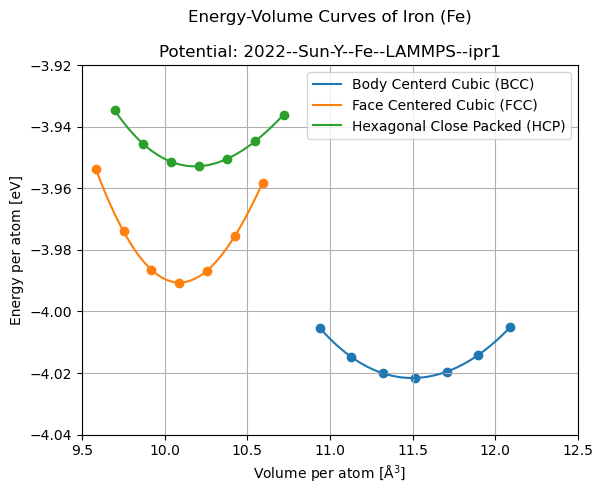

In [16]:
wf_gui = pf.get_workflow()
_ = wf_gui()

In [17]:
from ob.openbis import openbis_login, flatten_cdict, GenericCrystalObject
flatten_cdict(wf_gui.CreateStructure0.outputs.struct_and_cdict.value['cdict'])

{'lattice_parameter_a': 2.845,
 'lattice_angle_alpha': 90.0,
 'lattice_angle_beta': 90.0,
 'lattice_angle_gamma': 90.0,
 'lattice_volume': 23.0275,
 'space_group': 'Im-3m',
 'bravais_lattice': 'bcc',
 'Fe': 2,
 'total_number_atoms': 2,
 'simulation_cell_lengths': '[2.845, 2.845, 2.845]',
 'simulation_cell_vectors': '[array([2.845, 0.   , 0.   ]), array([0.   , 2.845, 0.   ]), array([0.   , 0.   , 2.845])]',
 'simulation_cell_angles': '[90.0, 90.0, 90.0]',
 'simulation_cell_volume': 23.0275,
 'workflow_manager': 'pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3, ',
 'structure_name': 'try1_Fe_bcc_input_structure',
 'project_name': 'try1_Fe',
 'path': '/home/tlakshmi/pyiron_workflow_20240611/pyiron_wf_openbis/try1_Fe/'}

In [18]:
o = openbis_login("https://test3.datastore.bam.de/", "tlakshmi")

Enter openBIS password:  ········


In [19]:
project_openbis = o.get_project("/TLAKSHMI/TEST")
project_openbis.get_objects(type = 'MAT_SIM_STRUCTURE.CRYSTAL')

,permId,identifier,registrationDate,modificationDate,type,registrator,modifier
0,20241025165654764-463,/TLAKSHMI/TEST/MAT_SIM_STR.CRY164,2024-10-25 16:56:55,2024-10-25 16:56:56,MAT_SIM_STRUCTURE.CRYSTAL,tlakshmi,tlakshmi
1,20241021101512172-329,/TLAKSHMI/TEST/MAT_SIM_STR.CRY118,2024-10-21 10:15:12,2024-10-21 10:15:17,MAT_SIM_STRUCTURE.CRYSTAL,tlakshmi,tlakshmi
2,20241025161133137-449,/TLAKSHMI/TEST/MAT_SIM_STR.CRY159,2024-10-25 16:11:33,2024-10-25 16:11:36,MAT_SIM_STRUCTURE.CRYSTAL,tlakshmi,tlakshmi


In [43]:
wf_gui.MurnaghanLammpsMacro0.pull()['murn_job'].input['vol_range']

0.05

In [21]:
GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_gui.ExtractEquilibriumStructure2.outputs.equil_struct_and_cdict.value['cdict'])


Structure already exists in project! Found structure in: /TLAKSHMI/TEST/MAT_SIM_STR.CRY164


Found structure properties:



property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_equilibrium_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.433,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,3.9731,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False
